In [12]:
import pandas as pd

# List the file names for the three days
files = [
    'prices_round_2_day_-1.csv',
    'prices_round_2_day_0.csv',
    'prices_round_2_day_1.csv'
]

# Load each CSV file from the directory and store the DataFrames in a list
dfs = [pd.read_csv(f'../round-2-island-data-bottle/{file}', delimiter=';') for file in files]

# Concatenate all DataFrames into one, resetting the index
df_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df_all.head())

   day  timestamp         product  bid_price_1  bid_volume_1  bid_price_2  \
0   -1          0      CROISSANTS         4304           112          NaN   
1   -1          0            JAMS         6670            66       6669.0   
2   -1          0       SQUID_INK         2005             1       2002.0   
3   -1          0  PICNIC_BASKET1        59284            20      59283.0   
4   -1          0  PICNIC_BASKET2        30606            20      30605.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0           NaN          NaN           NaN         4305           112   
1         137.0          NaN           NaN         6671            66   
2          31.0          NaN           NaN         2006            31   
3          18.0          NaN           NaN        59294             2   
4          18.0          NaN           NaN        30612            20   

   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0          NaN           NaN

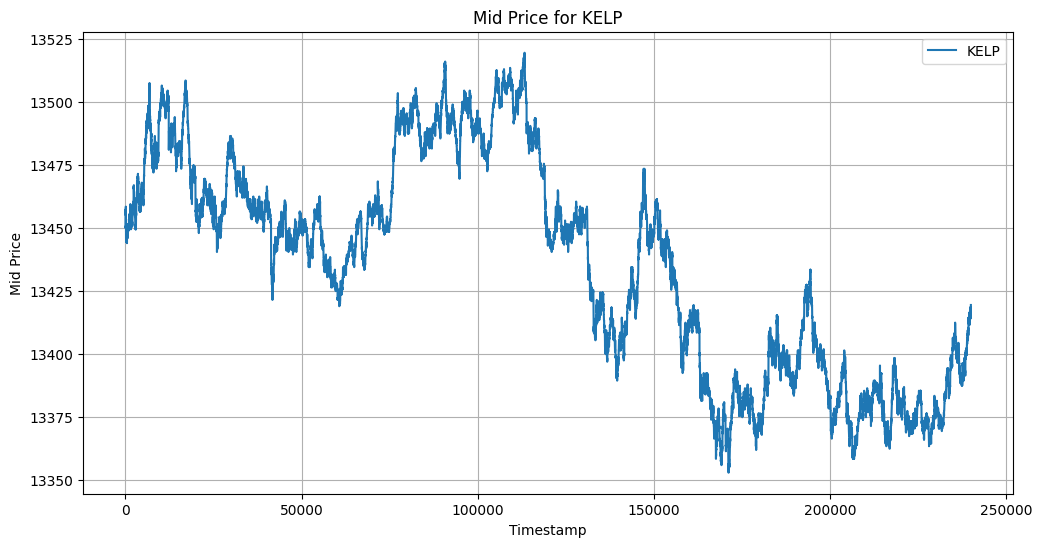

In [23]:
import matplotlib.pyplot as plt

# Plot for RAINFOREST_RESIN
plt.figure(figsize=(12, 6))
# plt.plot(df_all[df_all['product'] == 'CROISSANTS'].index, df_all[df_all['product'] == 'KELP']['mid_price'], label='KELP')
plt.plot(df_all[df_all['product'] == 'DJEMBES'].index, df_all[df_all['product'] == 'DJEMBES']['mid_price'], label='KELP')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.title('Mid Price for KELP')
plt.legend()
plt.grid(True)
plt.show()

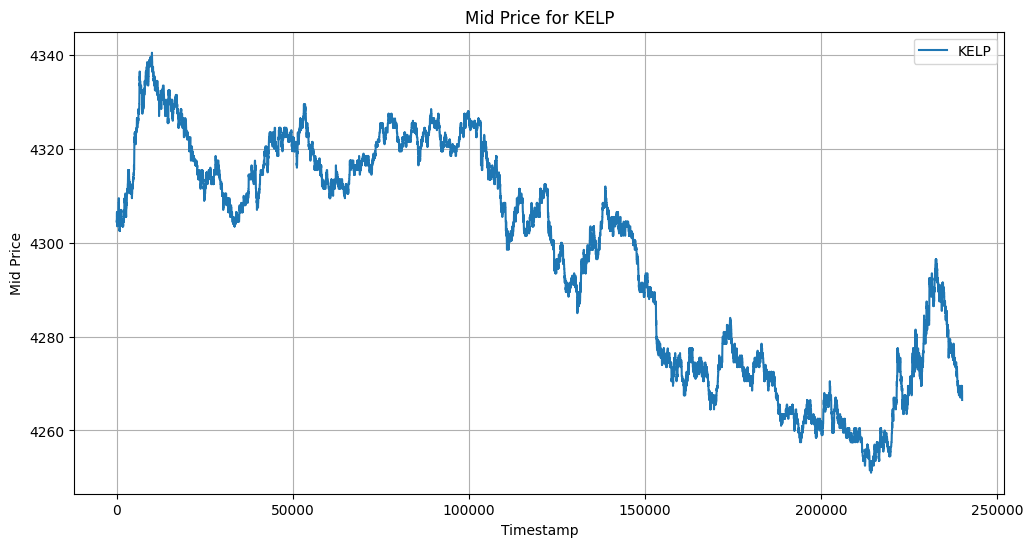

In [27]:
import matplotlib.pyplot as plt

# Plot for RAINFOREST_RESIN
plt.figure(figsize=(12, 6))
plt.plot(df_all[df_all['product'] == 'CROISSANTS'].index, df_all[df_all['product'] == 'CROISSANTS']['mid_price'], label='KELP')
# plt.plot(df_all[df_all['product'] == 'DJEMBES'].index, df_all[df_all['product'] == 'DJEMBES']['mid_price'], label='KELP')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.title('Mid Price for KELP')
plt.legend()
plt.grid(True)
plt.show()

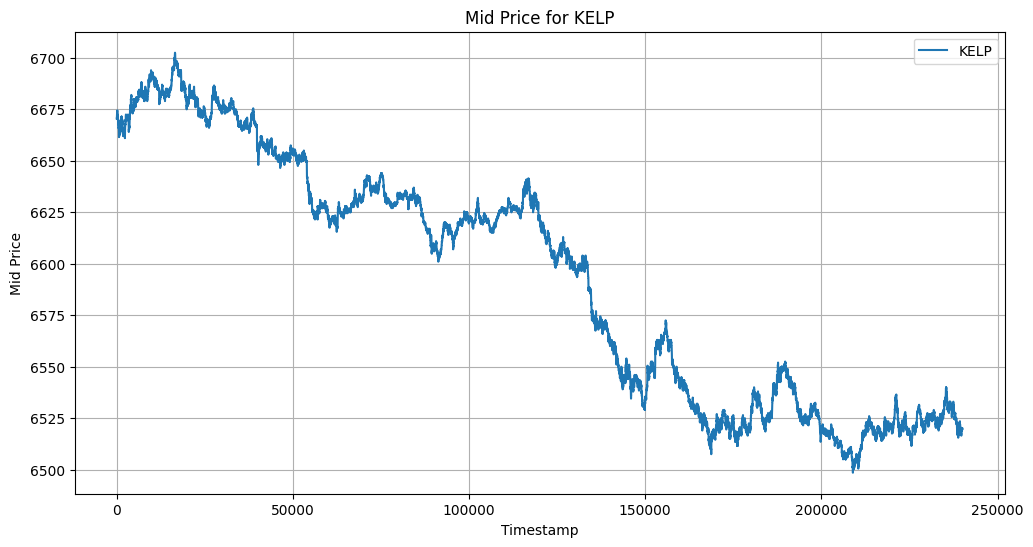

In [28]:
import matplotlib.pyplot as plt

# Plot for RAINFOREST_RESIN
plt.figure(figsize=(12, 6))
plt.plot(df_all[df_all['product'] == 'JAMS'].index, df_all[df_all['product'] == 'JAMS']['mid_price'], label='KELP')
# plt.plot(df_all[df_all['product'] == 'DJEMBES'].index, df_all[df_all['product'] == 'DJEMBES']['mid_price'], label='KELP')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.title('Mid Price for KELP')
plt.legend()
plt.grid(True)
plt.show()

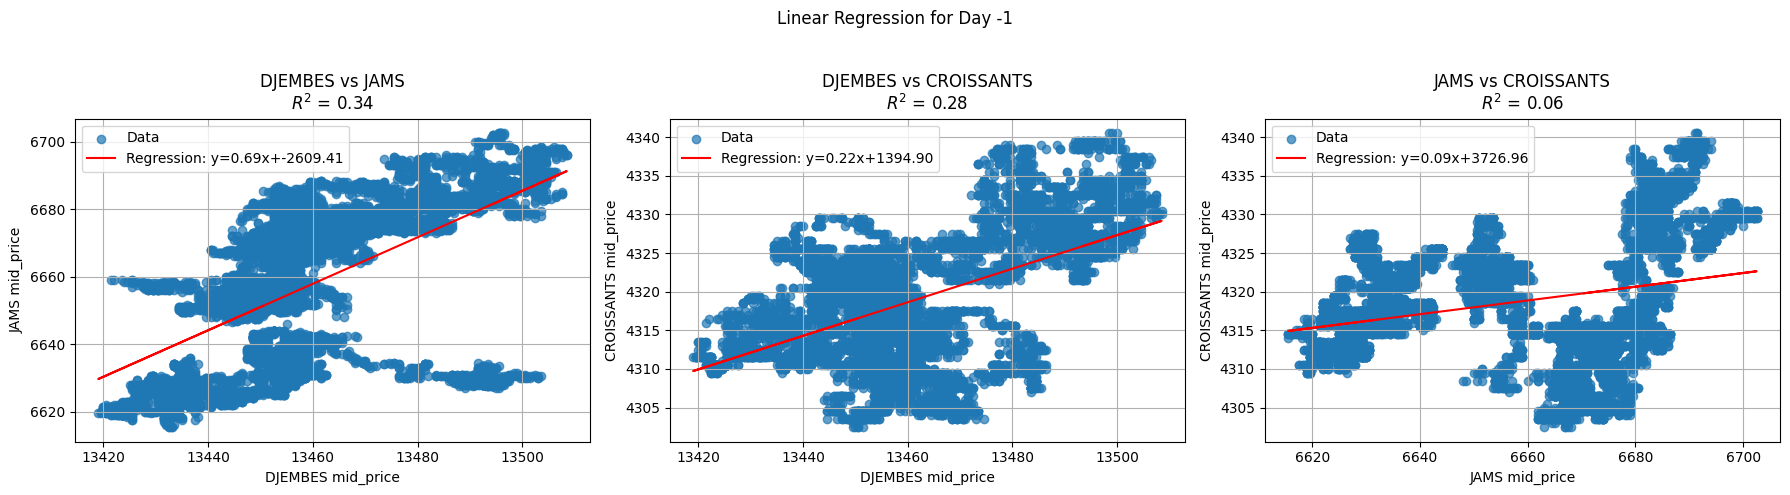

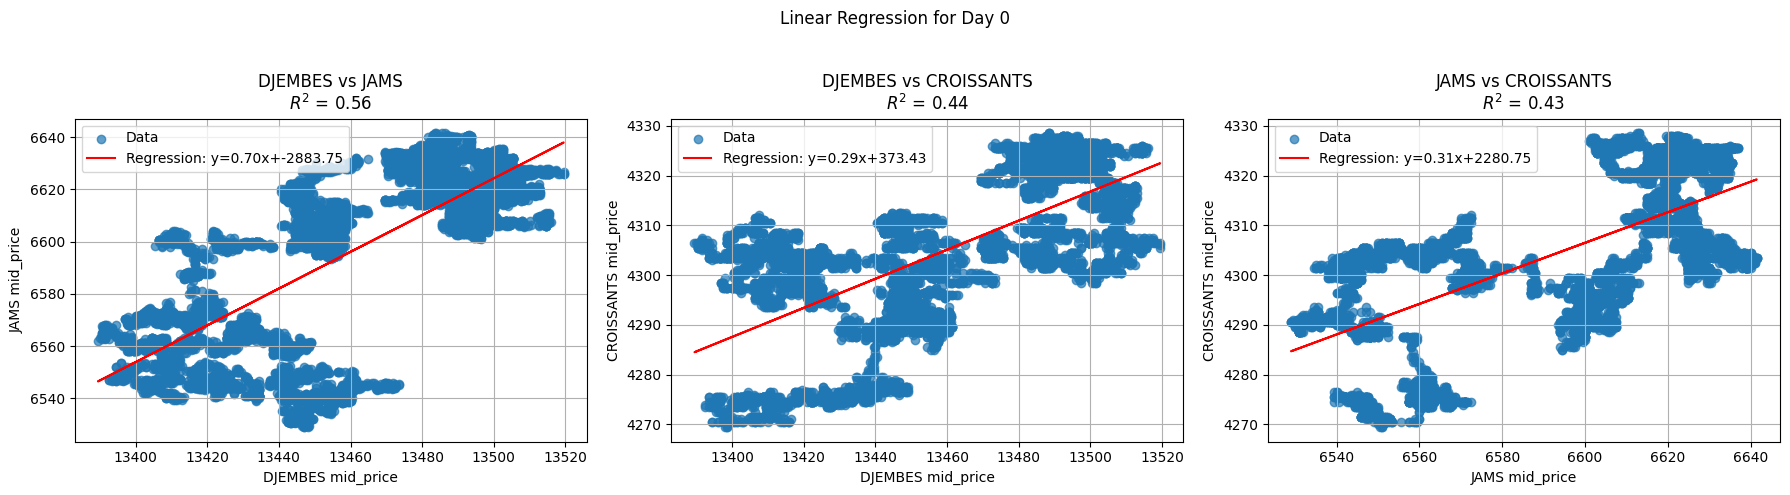

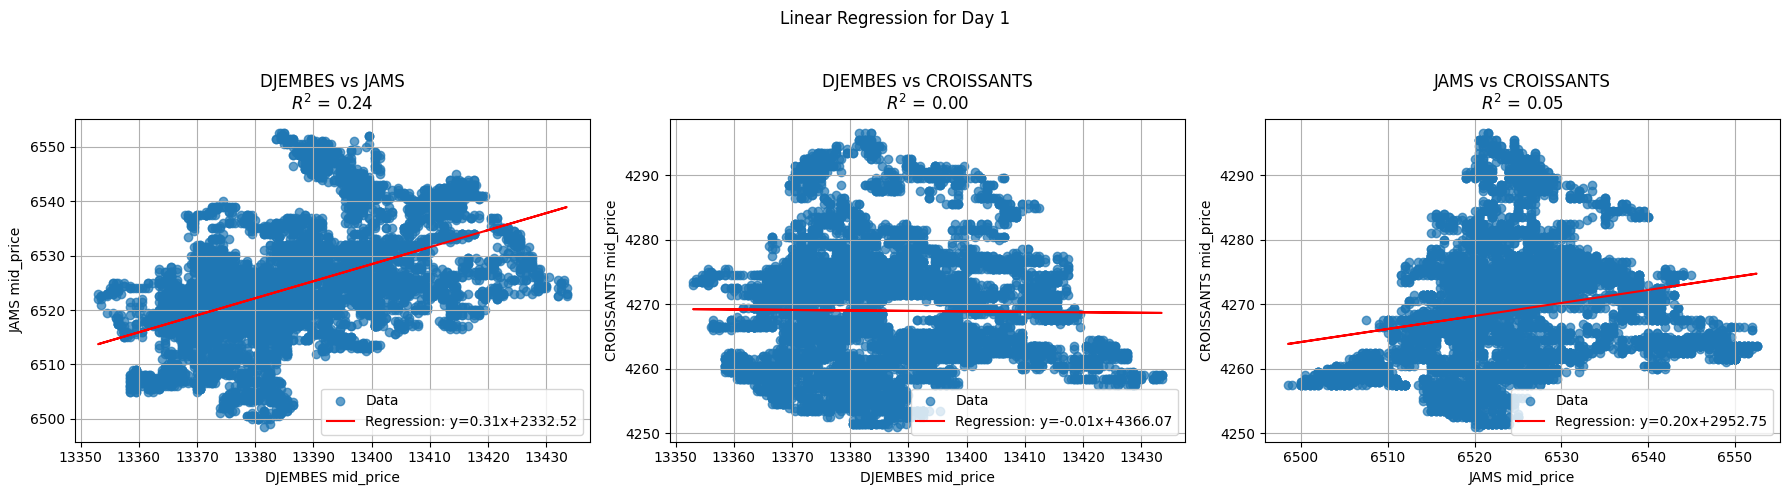

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import itertools
from scipy.stats import linregress

# List the filenames for the three days
files = [
    'prices_round_2_day_-1.csv',
    'prices_round_2_day_0.csv',
    'prices_round_2_day_1.csv'
]

def extract_day(filename):
    """Extract the day number from the filename using regex."""
    match = re.search(r'day_(-?\d+)', filename)
    return int(match.group(1)) if match else None

# Load each CSV, add a 'day' column, and collect the DataFrames
dfs = []
for file in files:
    df = pd.read_csv(f'../round-2-island-data-bottle/{file}', delimiter=';')
    df['day'] = extract_day(file)
    dfs.append(df)

# Concatenate all DataFrames into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Merge the data by pivoting so the index is timestamp and the columns are a MultiIndex (day, product)
merged_df = df_all.pivot_table(index='timestamp', columns=['day', 'product'], values='mid_price')

# Define the products of interest. Adjust these names as necessary.
products = ["DJEMBES", "JAMS", "CROISSANTS"]

# Loop through each day in the merged DataFrame
for day in merged_df.columns.levels[0]:
    # Extract the sub-dataframe for the given day. The resulting DataFrame has product names as columns.
    try:
        df_day = merged_df[day][products]
    except KeyError:
        # In case some products are missing for a day, skip this day or adjust the product list.
        print(f"Some products are missing for day {day}. Skipping regression for this day.")
        continue
        
    # Drop rows with any missing values to ensure proper alignment.
    df_day = df_day.dropna()
    if df_day.empty:
        print(f"No common timestamp data for day {day}. Skipping.")
        continue

    # Generate pair combinations among the products.
    product_pairs = list(itertools.combinations(products, 2))
    n_pairs = len(product_pairs)
    
    # Create subplots for each pair
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5), sharex=False, sharey=False)
    
    # If there's only one pair, wrap axes in a list to iterate over it
    if n_pairs == 1:
        axes = [axes]
    
    fig.suptitle(f"Linear Regression for Day {day}")
    
    # Perform regression for each pair and plot the results.
    for ax, (prod1, prod2) in zip(axes, product_pairs):
        # Get the data for the pair
        x = df_day[prod1].values
        y = df_day[prod2].values
        
        # Perform linear regression (y = slope * x + intercept)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        # Evaluate the regression line for each x
        reg_line = slope * x + intercept
        
        # Plot the scatter of data and the regression line
        ax.scatter(x, y, alpha=0.7, label='Data')
        ax.plot(x, reg_line, color='red', label=f'Regression: y={slope:.2f}x+{intercept:.2f}')
        ax.set_xlabel(f"{prod1} mid_price")
        ax.set_ylabel(f"{prod2} mid_price")
        ax.set_title(f"{prod1} vs {prod2}\n$R^2$ = {r_value**2:.2f}")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

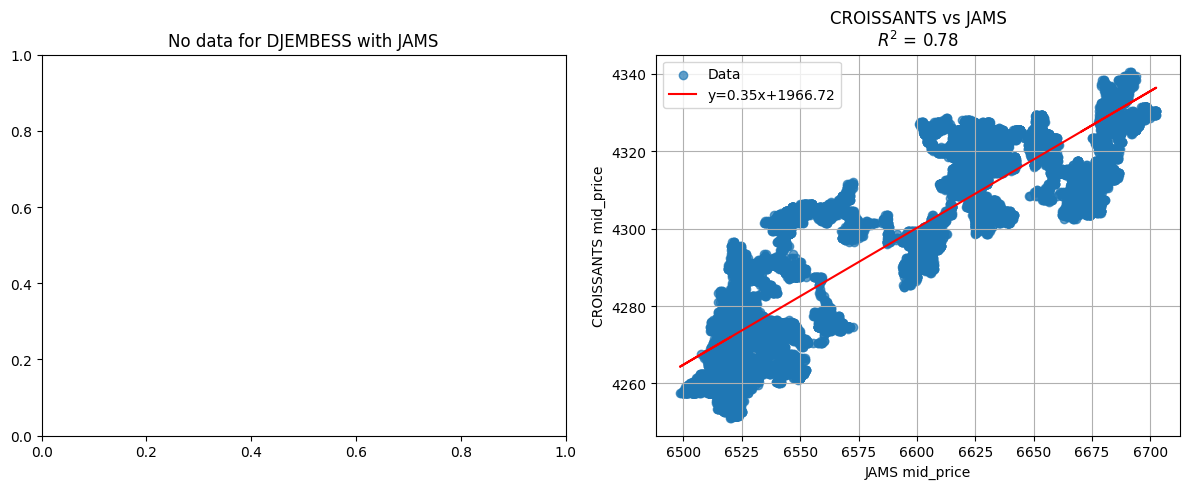

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import linregress

# List the filenames for the three days
files = [
    'prices_round_2_day_-1.csv',
    'prices_round_2_day_0.csv',
    'prices_round_2_day_1.csv'
]

def extract_day(filename):
    """Extract the day number from the filename."""
    match = re.search(r'day_(-?\d+)', filename)
    return int(match.group(1)) if match else None

# Load each CSV, add a 'day' column, and gather the DataFrames
dfs = []
for file in files:
    df = pd.read_csv(f'../round-2-island-data-bottle/{file}', delimiter=';')
    df['day'] = extract_day(file)
    dfs.append(df)

# Concatenate data from all days
df_all = pd.concat(dfs, ignore_index=True)

# Create a pivot table to merge by timestamp.
# This re-arranges the data so that the index is 'timestamp' and columns are a MultiIndex (day, product).
merged_df = df_all.pivot_table(index='timestamp', columns=['day', 'product'], values='mid_price')

# Define the independent product and the dependent products.
indep_product = "JAMS"
dependent_products = ["DJEMBESS", "CROISSANTS"]

# Accumulate data from all days
combined_data = {}
for dep in dependent_products:
    x_all = []
    y_all = []
    for day in merged_df.columns.levels[0]:
        try:
            # Extract columns for JAMS and the dependent product for the given day
            df_day = merged_df[day][[indep_product, dep]].dropna()
        except KeyError:
            continue
        x_all.extend(df_day[indep_product].values)
        y_all.extend(df_day[dep].values)
    combined_data[dep] = (np.array(x_all), np.array(y_all))

# Perform linear regression for each dependent product vs. JAMS and plot the results.
fig, axes = plt.subplots(1, len(dependent_products), figsize=(6 * len(dependent_products), 5))
if len(dependent_products) == 1:
    axes = [axes]

for ax, dep in zip(axes, dependent_products):
    x, y = combined_data[dep]
    if len(x) == 0 or len(y) == 0:
        ax.set_title(f"No data for {dep} with {indep_product}")
        continue
    # Compute linear regression: y = slope * x + intercept
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    reg_line = slope * x + intercept

    # Plot the scatter and regression line
    ax.scatter(x, y, alpha=0.7, label='Data')
    ax.plot(x, reg_line, color='red', label=f'y={slope:.2f}x+{intercept:.2f}')
    ax.set_xlabel(f'{indep_product} mid_price')
    ax.set_ylabel(f'{dep} mid_price')
    ax.set_title(f'{dep} vs {indep_product}\n$R^2$ = {r_value**2:.2f}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display

# List filenames for the three days
files = [
    'prices_round_2_day_-1.csv',
    'prices_round_2_day_0.csv',
    'prices_round_2_day_1.csv'
]

def extract_day(filename):
    """Extract the day from the filename."""
    match = re.search(r'day_(-?\d+)', filename)
    return int(match.group(1)) if match else None

# Read each file, add a 'day' column, and gather DataFrames
dfs = []
for file in files:
    df = pd.read_csv(f'../round-2-island-data-bottle/{file}', delimiter=';')
    df['day'] = extract_day(file)
    dfs.append(df)

# Concatenate data from all three days
df_all = pd.concat(dfs, ignore_index=True)

# Filter for the three products of interest
products = ["DJEMBES", "CROISSANTS", "JAMS"]
df_filtered = df_all[df_all['product'].isin(products)]

# Create a pivot table with index ['timestamp', 'day'] and columns 'product'
pivot_df = df_filtered.pivot_table(index=['timestamp', 'day'], columns='product', values='mid_price')

# Remove rows with missing values to get valid observations for all three products
data = pivot_df.dropna()

# Our independent variables are DJEMBES and CROISSANTS, and the dependent variable is JAMS.
X = data[['DJEMBES', 'CROISSANTS']].values
Y = data['JAMS'].values

# Fit a multiple linear regression model
model = LinearRegression().fit(X, Y)
r2 = model.score(X, Y)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2:", r2)

# Create a 3D scatter plot with the regression plane
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter the data points
sc = ax.scatter(X[:, 0], X[:, 1], Y, color='blue', label='Data')

# Create a mesh grid to plot the regression plane
x_surf, y_surf = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 20),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
)
# Predict Z values (JAMS) for each (DJEMBES, CROISSANTS) pair
z_surf = model.predict(np.c_[x_surf.ravel(), y_surf.ravel()]).reshape(x_surf.shape)

# Plot the regression plane (with transparency)
surf = ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.5, color='red', rstride=1, cstride=1)

ax.set_xlabel('DJEMBES mid_price')
ax.set_ylabel('CROISSANTS mid_price')
ax.set_zlabel('JAMS mid_price')
ax.set_title(f'Multiple Linear Regression\n$R^2$ = {r2:.2f}')
ax.legend()

# Function to update the view based on the slider
def update_view(angle):
    ax.view_init(elev=30, azim=angle)
    fig.canvas.draw_idle()

# Create an interactive slider to change the azimuth angle
angle_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=360,
    step=2,
    description='Angle:',
    continuous_update=True
)
widgets.interactive(update_view, angle=angle_slider)
display(angle_slider)

FileNotFoundError: [Errno 2] No such file or directory: '../round-2-island-data-bottle/prices_round_2_day_-1.csv'